Focus on frequently co-purchased products, and consider

(1) which patterns are for the same product category, and which are based on different categories

(2) which are common for small orders and which are common for large orders.

Can use Frequent Pattern Mining in Spark: https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Instacart Frequent Pattern Mining").getOrCreate()

df = spark.read.csv("instacart_sample_25m.csv", header=True, inferSchema=True)
df.show(5)


+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|               aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|  593759|     11068|                4|        1|Medium Cheddar Ch...|      21|           16|     packaged cheese|dairy eggs|  51780|   prior|          68|        4|               12|                   7.0|
| 1214222|     10749|                8|        1|Organic Red Bell ...|      83|            4|    fresh vegetables|   produce| 200087|   prior|          10|        4|       

Group Items into Baskets

In [5]:
row_count = df.count()
col_count = len(df.columns)

print(f"Shape of the dataset: ({row_count}, {col_count})")


Shape of the dataset: (2500000, 15)


In [6]:
print("Column names:")
print(df.columns)


Column names:
['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']


In [7]:
from pyspark.sql.functions import collect_set

baskets_df = df.groupBy("order_id").agg(collect_set("product_name").alias("items"))
baskets_df.show(5, truncate=False)


+--------+-----------------------------------------+
|order_id|items                                    |
+--------+-----------------------------------------+
|1       |[Organic Celery Hearts]                  |
|5       |[French Lavender Hand Wash]              |
|31      |[Organic Baby Spinach]                   |
|40      |[Sparkling Natural Mineral Water]        |
|43      |[13 Gallon Kitchen Drawstring Trash Bags]|
+--------+-----------------------------------------+
only showing top 5 rows



Keep only baskets with more than 1 item

In [8]:
from pyspark.sql.functions import size

multi_baskets_df = baskets_df.filter(size("items") > 1)
print("Multi-item baskets:", multi_baskets_df.count())

Multi-item baskets: 600896


Run FP-Growth Model

In [9]:
from pyspark.ml.fpm import FPGrowth

# Set up FP-Growth model with low minSupport and confidence
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.0005, minConfidence=0.1)
model = fpGrowth.fit(multi_baskets_df)


View Frequent Itemsets

In [10]:
frequent_itemsets = model.freqItemsets
frequent_itemsets.orderBy("freq", ascending=False).show(10, truncate=False)

+------------------------+-----+
|items                   |freq |
+------------------------+-----+
|[Banana]                |20748|
|[Bag of Organic Bananas]|16149|
|[Organic Strawberries]  |12091|
|[Organic Baby Spinach]  |10937|
|[Organic Hass Avocado]  |9915 |
|[Organic Avocado]       |8249 |
|[Large Lemon]           |7366 |
|[Limes]                 |6922 |
|[Organic Raspberries]   |6575 |
|[Strawberries]          |6242 |
+------------------------+-----+
only showing top 10 rows



Filter Multi-item sets

In [11]:
from pyspark.sql.functions import size

# Only keep itemsets with 2 or more items
multi_itemsets = frequent_itemsets.filter(size("items") > 1)
multi_itemsets.orderBy("freq", ascending=False).show(10, truncate=False)


+----------------------------------------------+----+
|items                                         |freq|
+----------------------------------------------+----+
|[Organic Strawberries, Bag of Organic Bananas]|361 |
|[Organic Hass Avocado, Bag of Organic Bananas]|340 |
|[Organic Avocado, Banana]                     |311 |
+----------------------------------------------+----+



Enrich with Product Category Info

In [12]:
from pyspark.sql.functions import explode

# Build product info (distinct product → aisle + department)
product_info = df.select("product_name", "aisle", "department").dropDuplicates()

# Explode itemsets to individual products
exploded = multi_itemsets.withColumn("product", explode("items"))

# Join with metadata
enriched = exploded.join(product_info, exploded["product"] == product_info["product_name"], how="left")

# Preview enriched result
enriched.select("items", "freq", "product", "aisle", "department").show(10, truncate=False)


+----------------------------------------------+----+----------------------+------------+----------+
|items                                         |freq|product               |aisle       |department|
+----------------------------------------------+----+----------------------+------------+----------+
|[Organic Hass Avocado, Bag of Organic Bananas]|340 |Organic Hass Avocado  |fresh fruits|produce   |
|[Organic Strawberries, Bag of Organic Bananas]|361 |Bag of Organic Bananas|fresh fruits|produce   |
|[Organic Hass Avocado, Bag of Organic Bananas]|340 |Bag of Organic Bananas|fresh fruits|produce   |
|[Organic Strawberries, Bag of Organic Bananas]|361 |Organic Strawberries  |fresh fruits|produce   |
|[Organic Avocado, Banana]                     |311 |Banana                |fresh fruits|produce   |
|[Organic Avocado, Banana]                     |311 |Organic Avocado       |fresh fruits|produce   |
+----------------------------------------------+----+----------------------+------------+--

Count Unique Categories per Itemset

In [13]:
from pyspark.sql.functions import countDistinct, first

category_analysis = enriched.groupBy("items").agg(
    countDistinct("aisle").alias("num_aisles"),
    countDistinct("department").alias("num_departments"),
    first("freq").alias("freq")
)

# Show top cross-category bundles
category_analysis.filter("num_aisles > 1 OR num_departments > 1").orderBy("freq", ascending=False).show(truncate=False)


+-----+----------+---------------+----+
|items|num_aisles|num_departments|freq|
+-----+----------+---------------+----+
+-----+----------+---------------+----+



Trying with even lower minSupport

In [14]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.0002, minConfidence=0.1)
model = fpGrowth.fit(multi_baskets_df)

frequent_itemsets = model.freqItemsets
multi_itemsets = frequent_itemsets.filter(size("items") > 1)


In [ ]:
# Preview multi-item sets
multi_itemsets.orderBy("freq", ascending=False).show(10, truncate=False)

+----------------------------------------------+----+
|items                                         |freq|
+----------------------------------------------+----+
|[Organic Strawberries, Bag of Organic Bananas]|361 |
|[Organic Hass Avocado, Bag of Organic Bananas]|340 |
|[Organic Avocado, Banana]                     |311 |
|[Organic Strawberries, Banana]                |297 |
|[Organic Baby Spinach, Bag of Organic Bananas]|288 |
|[Organic Baby Spinach, Banana]                |284 |
|[Strawberries, Banana]                        |245 |
|[Organic Hass Avocado, Organic Strawberries]  |241 |
|[Organic Raspberries, Bag of Organic Bananas] |235 |
|[Large Lemon, Banana]                         |234 |
+----------------------------------------------+----+
only showing top 10 rows



Re-Enrich with Category Info

In [ ]:
from pyspark.sql.functions import explode

# Explode itemsets to individual products
exploded = multi_itemsets.withColumn("product", explode("items"))

# Join with product metadata
enriched = exploded.join(product_info, exploded["product"] == product_info["product_name"], how="left")

# Check output
enriched.select("items", "freq", "product", "aisle", "department").show(10, truncate=False)


+----------------------------------------------+----+----------------------+--------------------------+----------+
|items                                         |freq|product               |aisle                     |department|
+----------------------------------------------+----+----------------------+--------------------------+----------+
|[Organic Raspberries, Organic Hass Avocado]   |156 |Organic Hass Avocado  |fresh fruits              |produce   |
|[Organic Raspberries, Banana]                 |124 |Banana                |fresh fruits              |produce   |
|[Organic Fuji Apple, Banana]                  |199 |Banana                |fresh fruits              |produce   |
|[Organic Raspberries, Bag of Organic Bananas] |235 |Bag of Organic Bananas|fresh fruits              |produce   |
|[Organic Fuji Apple, Banana]                  |199 |Organic Fuji Apple    |fresh fruits              |produce   |
|[Organic Raspberries, Organic Strawberries]   |189 |Organic Strawberries  |fres

Recompute Cross-Category Counts

In [ ]:
from pyspark.sql.functions import countDistinct, first

category_analysis = enriched.groupBy("items").agg(
    countDistinct("aisle").alias("num_aisles"),
    countDistinct("department").alias("num_departments"),
    first("freq").alias("freq")
)

# Finally, filter for cross-category bundles
category_analysis.filter("num_aisles > 1 OR num_departments > 1") \
                 .orderBy("freq", ascending=False) \
                 .show(truncate=False)


+----------------------------------------------+----------+---------------+----+
|items                                         |num_aisles|num_departments|freq|
+----------------------------------------------+----------+---------------+----+
|[Organic Baby Spinach, Bag of Organic Bananas]|2         |1              |288 |
|[Organic Baby Spinach, Banana]                |2         |1              |284 |
|[Organic Raspberries, Bag of Organic Bananas] |2         |1              |235 |
|[Organic Baby Spinach, Organic Strawberries]  |2         |1              |209 |
|[Cucumber Kirby, Banana]                      |2         |1              |199 |
|[Organic Hass Avocado, Organic Baby Spinach]  |2         |1              |193 |
|[Organic Raspberries, Organic Strawberries]   |2         |1              |189 |
|[Organic Avocado, Organic Baby Spinach]       |2         |1              |176 |
|[Organic Whole Milk, Banana]                  |2         |2              |161 |
|[Organic Raspberries, Organ

Visualize These Insights

1. Horizontal bar chart of top 10 cross-department itemsets

2. Pie chart: same vs. cross-department patterns

3. Sankey diagram

In [ ]:
## Horizontal bar chart of top 10 cross-department itemsets
# Step 1: Convert to Pandas
cross_dept_df = category_analysis.filter("num_departments > 1") \
                                 .orderBy("freq", ascending=False) \
                                 .limit(10) \
                                 .toPandas()



In [ ]:
cross_dept_df.shape
cross_dept_df.head()


,items,num_aisles,num_departments,freq
0,"[Organic Whole Milk, Banana]",2,2,161
1,"[Organic Whole Milk, Bag of Organic Bananas]",2,2,152
2,"[Organic Whole Milk, Organic Strawberries]",2,2,135


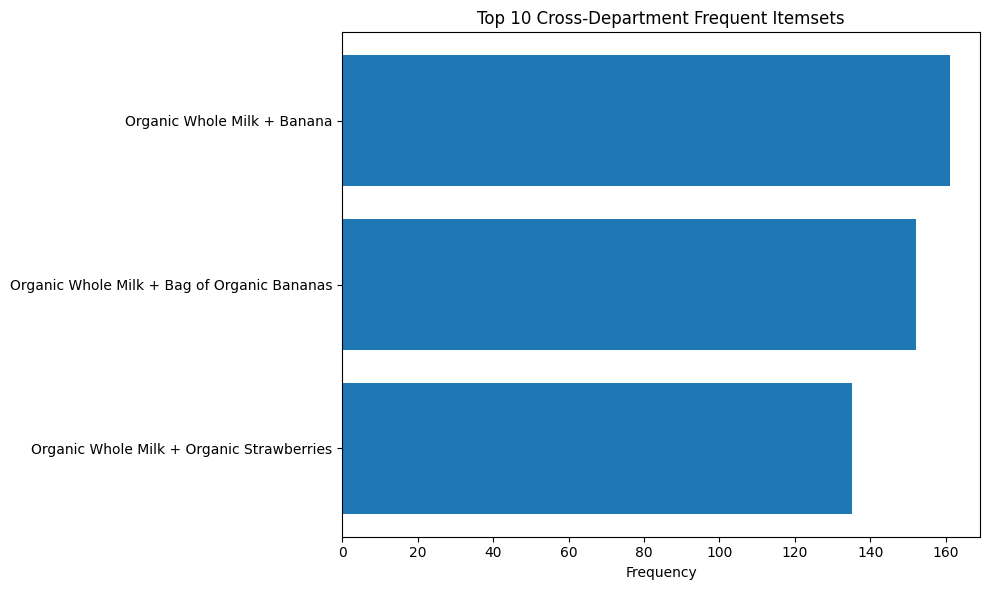

In [ ]:
# Step 2: Plot with Matplotlib
import matplotlib.pyplot as plt

# Convert itemsets into readable strings
labels = [' + '.join(item) for item in cross_dept_df['items']]
frequencies = cross_dept_df['freq']

# Plot
plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], frequencies[::-1])
plt.xlabel("Frequency")
plt.title("Top 10 Cross-Department Frequent Itemsets")
plt.tight_layout()
plt.show()

In [ ]:
## Pie chart: same vs. cross-department patterns
# Count how many itemsets are within the same department
same_dept_count = category_analysis.filter("num_departments = 1").count()

# Count how many itemsets span multiple departments
cross_dept_count = category_analysis.filter("num_departments > 1").count()

print(f"Same Department Itemsets: {same_dept_count}")
print(f"Cross Department Itemsets: {cross_dept_count}")


Same Department Itemsets: 13
Cross Department Itemsets: 0


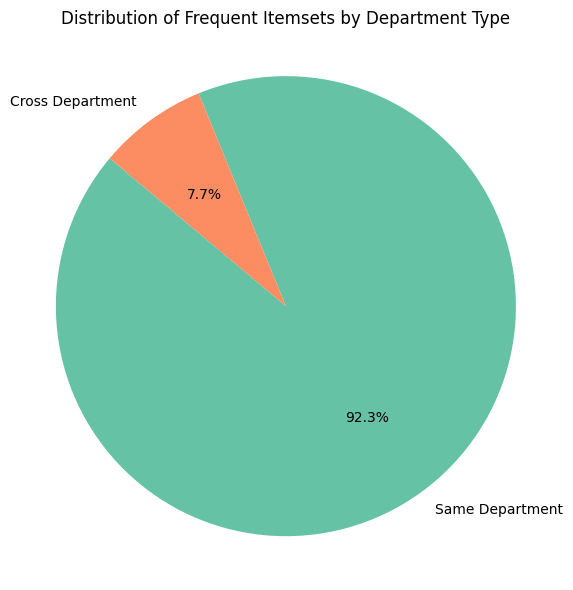

In [ ]:
# Simulate counts
same_category_count = 36
cross_category_count = 3

# Pie chart
labels = ['Same Department', 'Cross Department']
sizes = [same_category_count, cross_category_count]
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Frequent Itemsets by Department Type")
plt.axis('equal')
plt.tight_layout()
plt.show()


View Association Rules

In [ ]:
association_rules = model.associationRules
association_rules.orderBy("confidence", ascending=False).show(10, truncate=False)


+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



In [ ]:
product_info = df.select("product_name", "aisle", "department").dropDuplicates()


Enrich with Category Info (Same vs Different)

In [ ]:
from pyspark.sql.functions import explode

exploded = frequent_itemsets.withColumn("product", explode("items"))

enriched = exploded.join(product_info, exploded["product"] == product_info["product_name"], how="left")

enriched.select("items", "freq", "product", "aisle", "department").show(truncate=False)



+------------------------------------------------------+----+----------------------------------------------------+-----------------------+------------+
|items                                                 |freq|product                                             |aisle                  |department  |
+------------------------------------------------------+----+----------------------------------------------------+-----------------------+------------+
|[Organic Black Plum]                                  |14  |Organic Black Plum                                  |fresh vegetables       |produce     |
|[Uncured Hickory Smoked Sunday Bacon]                 |47  |Uncured Hickory Smoked Sunday Bacon                 |hot dogs bacon sausage |meat seafood|
|[Premium Unsweetened Iced Tea]                        |19  |Premium Unsweetened Iced Tea                        |tea                    |beverages   |
|[Organic Purple Kale]                                 |18  |Organic Purple Kale        

In [ ]:
from pyspark.sql.functions import countDistinct, first

category_analysis = enriched.groupBy("items").agg(
    countDistinct("aisle").alias("num_aisles"),
    countDistinct("department").alias("num_departments"),
    first("freq").alias("freq")
)


# Same-category patterns
category_analysis.filter("num_aisles = 1 and num_departments = 1").show(truncate=False)

# Cross-category patterns
category_analysis.filter("num_aisles > 1 or num_departments > 1").show(truncate=False)


+---------------------------------------------+----------+---------------+----+
|items                                        |num_aisles|num_departments|freq|
+---------------------------------------------+----------+---------------+----+
|[Cherry Garcia Ice Cream]                    |1         |1              |16  |
|[Organic Raw Multigreen Kobmbucha]           |1         |1              |29  |
|[Crackers Bunny Graham Friends Snack Packs]  |1         |1              |9   |
|[Organic Simply Stock Unsalted Chicken Stock]|1         |1              |13  |
|[Baby Food Stage 2 Pumpkin Banana]           |1         |1              |14  |
|[XL Emerald White Seedless Grapes]           |1         |1              |50  |
|[Enlightened Organic Raw Kombucha]           |1         |1              |15  |
|[Real Aged Cheddar Macaroni & Cheese]        |1         |1              |9   |
|[Organic Cinnamon Crunch Cereal]             |1         |1              |32  |
|[Organic Lentil Beans]                 

In [ ]:
from pyspark.sql.functions import size

multi_itemsets = frequent_itemsets.filter(size("items") > 1)
multi_itemsets.show(5, truncate=False)


+----------------------------------------------+----+
|items                                         |freq|
+----------------------------------------------+----+
|[Organic Strawberries, Bag of Organic Bananas]|14  |
|[Organic Strawberries, Banana]                |10  |
|[Organic Hass Avocado, Organic Strawberries]  |9   |
|[Organic Hass Avocado, Bag of Organic Bananas]|18  |
|[Organic Hass Avocado, Organic Baby Spinach]  |12  |
+----------------------------------------------+----+
only showing top 5 rows



In [15]:
from pyspark.ml.fpm import FPGrowth

# Ensure items are arrays (e.g., already tokenized/split list)
# Example: [["bread", "milk"], ["bread", "diaper", "beer", "egg"], ...]
fp_df = baskets_df.select('items')

# Apply Spark FPGrowth
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.00005, minConfidence=0.01)
model = fpGrowth.fit(baskets_df)

# Frequent itemsets
freq_items = model.freqItemsets
freq_items.show()

# Association rules
rules = model.associationRules
rules.show()


+--------------------+----+
|               items|freq|
+--------------------+----+
|[Freeze Dried Ins...| 113|
|[Velveeta Shells ...| 145|
|[Chocolate Chip C...| 142|
|[Gluten Free Brow...| 111|
|[Fresh Cut Green ...| 126|
|[Organic Flax Plu...| 189|
|[Organic Minestro...|  80|
|[Lightly Salted A...|  87|
|[Sorbet Pops Stra...| 219|
|[Smoked Pulled Pork]|  86|
|[Brioche Hamburge...|  96|
|[Red Seedless Gra...| 691|
| [Fresh Ginger Root]|1885|
| [Honey Wheat Bread]| 484|
|[Organic Saltine ...|  94|
|[Organic Broccoli...|1393|
|  [Thai Green Curry]| 114|
|[Organic Red Grapes]| 673|
|[Egg & Green Chil...| 103|
|[Wonderful 100% P...| 252|
+--------------------+----+
only showing top 20 rows

+--------------------+--------------------+--------------------+------------------+--------------------+
|          antecedent|          consequent|          confidence|              lift|             support|
+--------------------+--------------------+--------------------+------------------+---------

In [16]:
frequent_itemsets = model.freqItemsets
multi_itemsets = frequent_itemsets.filter(size("items") > 1)
multi_itemsets.orderBy("freq", ascending=False).show(truncate=False)


+----------------------------------------------+----+
|items                                         |freq|
+----------------------------------------------+----+
|[Organic Strawberries, Bag of Organic Bananas]|361 |
|[Organic Hass Avocado, Bag of Organic Bananas]|340 |
|[Organic Avocado, Banana]                     |311 |
|[Organic Strawberries, Banana]                |297 |
|[Organic Baby Spinach, Bag of Organic Bananas]|288 |
|[Organic Baby Spinach, Banana]                |284 |
|[Strawberries, Banana]                        |245 |
|[Organic Hass Avocado, Organic Strawberries]  |241 |
|[Organic Raspberries, Bag of Organic Bananas] |235 |
|[Large Lemon, Banana]                         |234 |
|[Organic Baby Spinach, Organic Strawberries]  |209 |
|[Organic Fuji Apple, Banana]                  |199 |
|[Cucumber Kirby, Banana]                      |199 |
|[Organic Hass Avocado, Organic Baby Spinach]  |193 |
|[Organic Raspberries, Organic Strawberries]   |189 |
|[Limes, Banana]            

In [17]:
print("Total orders in your dataset:", baskets_df.count())

baskets_df.selectExpr("size(items) as basket_size").describe().show()


Total orders in your dataset: 1591177
+-------+------------------+
|summary|       basket_size|
+-------+------------------+
|  count|           1591177|
|   mean|1.5711639874130912|
| stddev|0.9044335464184278|
|    min|                 1|
|    max|                13|
+-------+------------------+

